## 설명 가능한 CNN

- 딥러닝 처리 결과를 사람이 이해할 수 있는 방식으로 제시하는 것

- 이미지에서 어떻게 특성이 추출되고 학습하는지 **시각적**으로 설명하는 것

---

#### feature map 시각화

##### (1) 라이브러리 호출

In [ ]:
import os
import time
import copy
import glob
import cv2
import shutil
from PIL import Image

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

##### (2) 학습 데이터 다운로드 및 전처리

In [ ]:
!git clone 'https://github.com/gilbutITbook/080289.git'

In [ ]:
data_path = '/content/080289/chap05/data/catanddog/train'

transform = transforms.Compose( # 이미지 변환
    [
        transforms.Resize([256, 256]), # 256x256 사이즈 조정
        transforms.RandomResizedCrop(224), # 랜덤으로 Crop
        transforms.RandomHorizontalFlip(), # 랜덤으로 수평 Flip
        transforms.ToTensor() # Tensor로 변환
    ]
)

train_dataset = torchvision.datasets.ImageFolder(
    root=data_path, # 데이터 경로
    transform=transform # 데이터 전처리
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, # DataLoader로 데이터 불러오기
    batch_size=32, # 한 번에 불러올 데이터 양
    num_workers=8,
    shuffle=True
)

len(train_dataset)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


385

##### (3) 모델 생성

In [143]:
class XAI(nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()

        # Conv Layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        # FC Layer
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias=False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        x = torch.nn.functional.log_softmax(x)
        return x

In [150]:
model = XAI()
model.to(device)
model

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

- `model.eval()` : 모델을 추론 모드로 전환

- 새로운 데이터에 대한 예측을 수행할 때, 가중치를 고정시켜서 파라미터가 업데이트되지 않도록 함

In [ ]:
model.eval()

##### (4) 이미지 준비

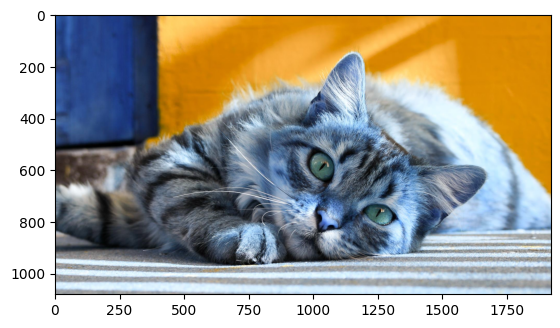

In [164]:
img = cv2.imread('/content/080289/chap05/data/cat.jpg')
plt.imshow(img)

*Interpolation : 보간법*

- 이미지 비율 변경 시, 존재하지 않는 영역에 픽셀 값을 할당해야 함

- 존재하는 픽셀에 대해 근사 함수를 적용하여 새로운 픽셀 값을 추정하고 할당하는 것

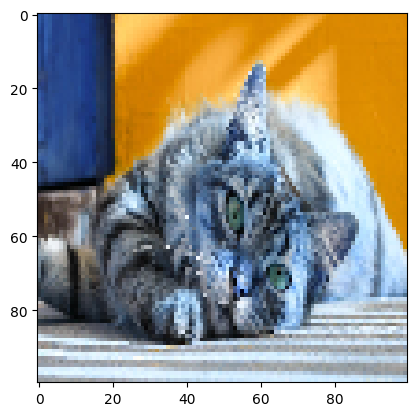

In [165]:
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
plt.imshow(img)

In [166]:
img = transforms.ToTensor()(img).unsqueeze(0)
img.shape

torch.Size([1, 3, 100, 100])

##### (5) feature map 확인

 - Pytorch의 **hook**은 중간 Layer에서 발생하는 연산의 결과를 출력하거나 조작하는 기능을 제공함

- `register_forward_hook()` : 순전파 과정에서 선택한 Layer의 **출력값**을 가져옴

In [227]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()

##### - 0번째 Layer의 feature map 확인

In [185]:
model.features[0]

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)

In [186]:
result = LayerActivations(model.features, 0)

model(img)
activations = result.features

<ipython-input-143-c973d648f3e7>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)


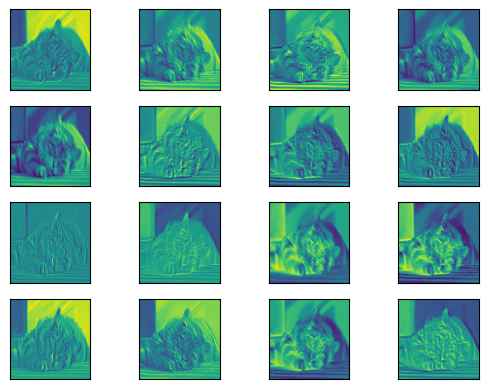

<Figure size 1200x800 with 0 Axes>

In [188]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        ax = axes[row][column]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(activations[0][row*10+column])

plt.show()

##### - 20번째 Layer의 feature map 확인

In [190]:
model.features[20]

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [191]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

<ipython-input-143-c973d648f3e7>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)


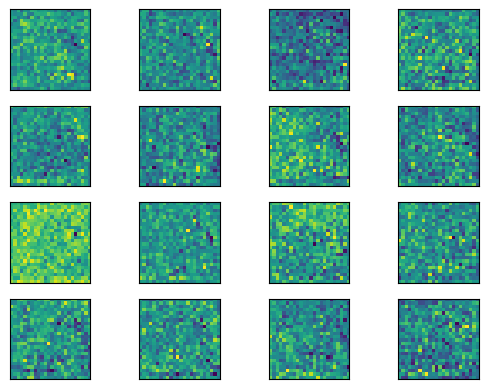

<Figure size 1200x800 with 0 Axes>

In [192]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        ax = axes[row][column]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(activations[0][row*10+column])

plt.show()

##### - 40번째 Layer의 feature map 확인

In [193]:
model.features[40]

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [194]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

<ipython-input-143-c973d648f3e7>:79: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.log_softmax(x)


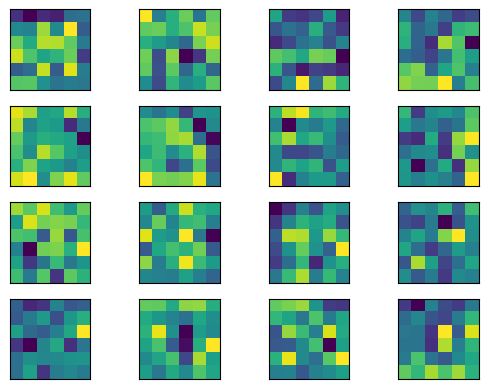

<Figure size 1200x800 with 0 Axes>

In [195]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for row in range(4):
    for column in range(4):
        ax = axes[row][column]
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        ax.imshow(activations[0][row*10+column])

plt.show()

-> 출력층에 가까울수록 원본의 형태를 잃어버리고, 이미지의 **특징**들만 전달되는 것을 확인함